# Real Estate Price Prediction: EDA & Feature Engineering (Part 1)

Author: **Marcin Sikorski**<br>
Date: January, 2024

Update of predicting house prices in Seattle (King County) - regression task. This part contains basic EDA (exploratory data analysis) and feature engineering. The final product of this notebook is a new dataset after transforming raw data source.

**Notebook Content:**
1. Loading and Exploring Dataset
2. Featuring Engineering
3. Multicollinearity and Feature Selection
4. Statistical Tests

### 1. Loading and Exploring Dataset

The basic libraries will be imported for further EDA and the raw data from URL address.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import data
def load_data():
    url = 'https://raw.githubusercontent.com/alawong1/King-County-House-Sales/master/kc_house_data.csv'
    dataframe = pd.read_csv(url, sep=',')
    
    # remove duplicates
    dataframe.drop_duplicates(inplace=True)
    
    return dataframe

df = load_data()
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,20141013T000000,20141209T000000,20150225T000000,20141209T000000,20150218T000000
price,221900.0,538000.0,180000.0,604000.0,510000.0
bedrooms,3,3,2,4,3
bathrooms,1.0,2.25,1.0,3.0,2.0
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1.0,2.0,1.0,1.0,1.0
waterfront,0,0,0,0,0
view,0,0,0,0,0


The dataset description:
* continuous numerical features: describe the area dimensions in measurements and the geospatial distribution of the real estate - `price`, `sqft_living`, `sqft_lot`, `sqft_above`, `sqft_basement`, `lat`, `long`, `sqft_living15`, `sqft_lot15`
* discrete variables: provide additional information on components of the house like number of previous selling price, bedrooms, floors, waterfornt, etc. - `date`, `bedrooms`, `bathrooms`, `floors`, `waterfront`, `view`, `condition`, `grade`, `yr_built`, `yr_renovated`, `zipcode`.

In [2]:
# remove 'id' column - not revelant for our analysis
df.drop(['id'], axis=1, inplace=True)

def columns_summary():
    print('Instances and features:')
    print(df.shape)
    
    # lists
    col_list = df.columns.to_list()
    count_list = df.count().to_list()
    dtype_list = df.dtypes.to_list()
    
    # stack lists into dataframe
    df_sum = pd.DataFrame(zip(col_list, count_list, dtype_list), columns=['Feature', 'Counts', 'Data type'])
    
    return df_sum.style.hide(axis='index')

columns_summary()

Instances and features:
(21613, 20)


Feature,Counts,Data type
date,21613,object
price,21613,float64
bedrooms,21613,int64
bathrooms,21613,float64
sqft_living,21613,int64
sqft_lot,21613,int64
floors,21613,float64
waterfront,21613,int64
view,21613,int64
condition,21613,int64


> Since the counts of each feature are equal to the total number of instanes, the dataset looks complete and has no missing values.

We will search for irrelevant values in the data column and numeric variables. We want to check if the values fit to their data type, for example if the `date` column, which is an object, does not contain words. The check function will coerce `date` from string to a datetime object and the remaining variables into a float. If all these columns truly have correct values, there shouldn’t be any errors or erroneous values.

In [3]:
def irrevalant_data():
    # check 'date' column
    incorrect_dates = []
    for val in df['date']:
        try:
            pd.to_datetime(val)
        except:
            incorrect_dates.append(val)
            
    print(f'Erroneous values in date column: {len(incorrect_dates)}')
    
    # get numeric columns
    not_object = df.select_dtypes(exclude=object).columns
    
    # check numeric columns
    incorrect_nums = []
    for col in not_object:
        for val in df[col].dropna():
            try:
                float(val)
            except:
                incorrect_nums.append(val)
                
    print(f'Erroneous values in numeric columns: {len(incorrect_nums)}')
    
irrevalant_data()

Erroneous values in date column: 0
Erroneous values in numeric columns: 0


> The check did not return any erroneous values.

The `sqft_living` seems to be the total sum of above footage (living rooms, bedrooms, closets, etc.) and basement footage. It is the most crucial feature for estimating prices.

In [4]:
(df['sqft_living'] == df['sqft_above'] + df['sqft_basement']).value_counts()

True    21613
dtype: int64

A heatmap will be plotted to display the spatial density of all houses.

In [5]:
#from folium import Map
#from folium.plugins import HeatMap
#from branca.element import Figure
#
#def plot_heatmap():    
#    fig = Figure(width=600, height=400)
#    
#    m_map = Map(location=[47.45, -121.9], zoom_start=9)
#    
#    HeatMap(data=df[['lat', 'long']].values, min_opacity=0.3, radius=22,
#            gradient={0: 'navy', 0.25: 'blue', 0.5: 'green', 0.75: 'yellow', 1: 'red'}).add_to(m_map)
#    
#    #df.apply(lambda x:folium.Circle(location=[x['lat'], x['long']], radius=50, fill=True,
#    #color=x['price']).add_to(m_map), axis=1)
#
#    return fig.add_child(m_map)
#
#plot_heatmap()

<img src='canvas.png' alt='drawing' width='600' height='400'/>

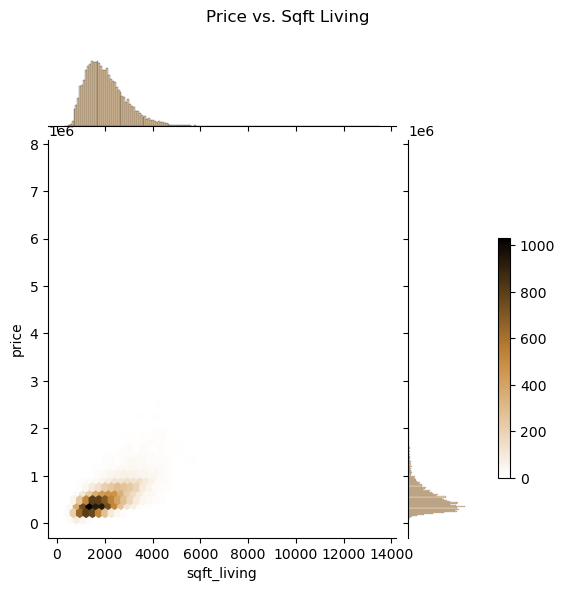

In [6]:
def density_plot():
    # outliers stretch frame limits, plot highlights how concentrated the features are
    hexplot = sns.jointplot(data=df, x='sqft_living', y='price', kind='hex', color='burlywood', height=6)
    plt.subplots_adjust(left=0.1, right=0.8, top=0.9, bottom=0.1) # make space for cbar
    hexplot.fig.suptitle('Price vs. Sqft Living')
    
    cbar_ax = hexplot.fig.add_axes([0.85, 0.2, 0.02, 0.4]) # x, y, width, height
    plt.colorbar(cax=cbar_ax)
    plt.show()
    
density_plot()

We will plot the geographical house locations to search for outliers. Additionally, we will plot Seattle's Downtown coordinates to check how the distance affects the price.

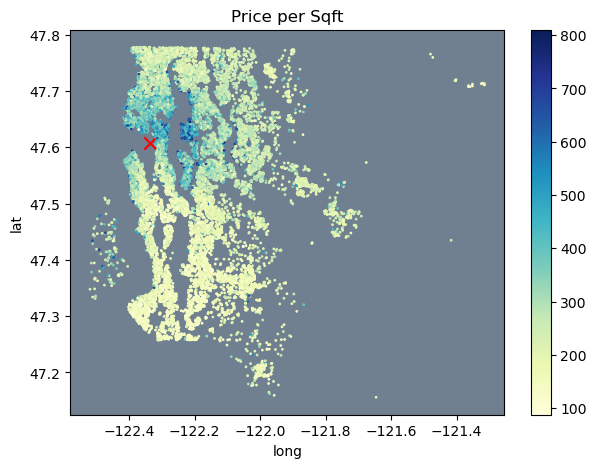

In [7]:
def price_distribution():
    plt.figure(figsize=(7, 5))
    
    # set plot background
    ax = plt.axes()
    ax.set_facecolor('slategrey')
    
    p = [47.608013, -122.335167] # Seattle's Downtown coordinates
    
    plt.scatter(x=p[1], y=p[0], marker='x', c='red', s=80)
    plt.scatter(x=df['long'], y=df['lat'], c=df['price']/df['sqft_living'],  s=1, cmap='YlGnBu')
    plt.title('Price per Sqft')
    plt.xlabel('long')
    plt.ylabel('lat')
    plt.colorbar()
    plt.show()
    
price_distribution()

No outliers in latitude and longtitude features. Based on this plot, we can notice that to a certain degree the price seems to go down as houses are further away from the city's downtown.

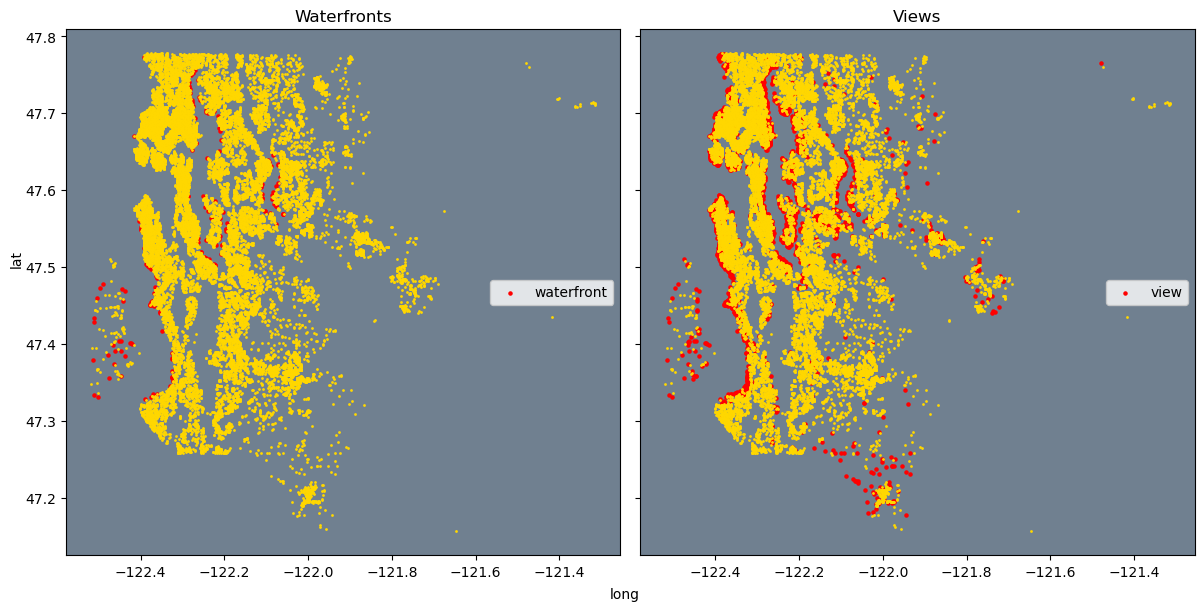

In [8]:
def waterfront_view_distribution():
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, tight_layout=True, figsize=(12, 6))
    fig.text(0.0001, 0.56, s='lat', rotation='vertical', va='center')
    fig.text(0.5, 0.0001, s='long', va='center')
    
    axes[0].scatter(x=df['long'][df['waterfront'] == 1], y=df['lat'][df['waterfront'] == 1], s=5, color='red',
                    label='waterfront')
    axes[0].scatter(x=df['long'][df['waterfront'] == 0], y=df['lat'][df['waterfront'] == 0], s=1, color='gold')
    axes[0].set(title='Waterfronts', facecolor='slategrey')
    axes[0].legend(loc='center right')
    
    axes[1].scatter(x=df['long'][df['view'] != 0], y=df['lat'][df['view'] != 0], s=5, color='red', label='view')
    axes[1].scatter(x=df['long'][df['view'] == 0], y=df['lat'][df['view'] == 0], s=1, color='gold')
    axes[1].set(title='Views', facecolor='slategrey')
    axes[1].legend(loc='center right')
    plt.show()
    
waterfront_view_distribution()

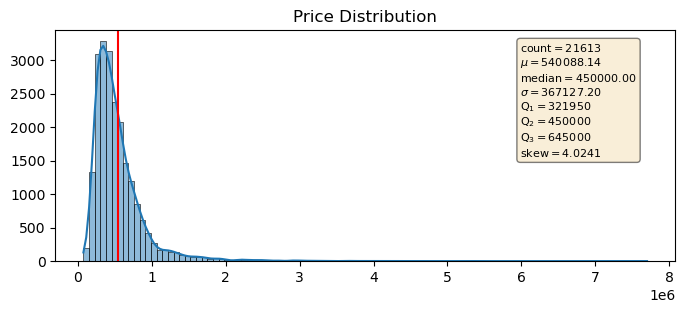

In [9]:
def feature_distribution(feature):
    fig, ax = plt.subplots(figsize=(8, 3))
    
    count = r'$\mathrm{count}=%.0f$' % (len(feature), )
    mu = r'$\mu=%.2f$' % (feature.mean(), )
    median = r'$\mathrm{median}=%.2f$' % (feature.median(), )
    sigma = r'$\sigma=%.2f$' % (feature.std(), )
    quant_25 = r'$\mathrm{Q_1}=%.0f$' % (feature.quantile(0.25), )
    quant_50 = r'$\mathrm{Q_2}=%.0f$' % (feature.quantile(0.50), )
    quant_75 = r'$\mathrm{Q_3}=%.0f$' % (feature.quantile(0.75), )
    skewness = r'$\mathrm{skew}=%.4f$' % (feature.skew(), )
    
    textstr = '\n'.join((count, mu, median, sigma, quant_25, quant_50, quant_75, skewness))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    histogram = sns.histplot(data=df, x=feature, kde=True, bins=100)
    histogram.set(title=f'{feature.name.capitalize()} Distribution', xlabel=None, ylabel=None)
    ax.axvline(x=feature.mean(), color='red') # plot mean value
    ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=8, verticalalignment='top', bbox=props)
    plt.show()
    
feature_distribution(df['price'])

> The target feature is very right-skewed (has a very long flat 'tail' in its distribution). Compairing the maximum price with the price at 75% quantile (\\$645,000), the `price` feature should have some outliers. We can delete records from where the tail starts (around \\$2M). Instead, we will replace prices greater than 99th percentile number with 99th percentile number. The same method will be applied in other numercial features.

In [10]:
# 99th percentile number
df['price'].quantile(0.99)

1964400.0000000051

In [11]:
df.loc[df['price'] > 1964400.0, 'price'] = 1964400.0

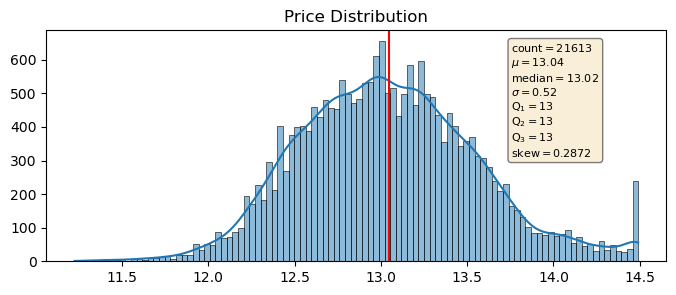

In [12]:
# natural logarithm distribution
feature_distribution(np.log(df['price']))

> Applying a logarithm transform makes the target distribution much more even which is a good sign. Performing regression should be possible.

In [13]:
# apply 99th percentile on continuous variables
for col in ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']:
    quant_99 = round(df[col].quantile(0.99), 1) # 99th percentile number
    df.loc[df[col] > quant_99, col] = quant_99

We will plot box plots for discrete features and check if they contain any outliers.

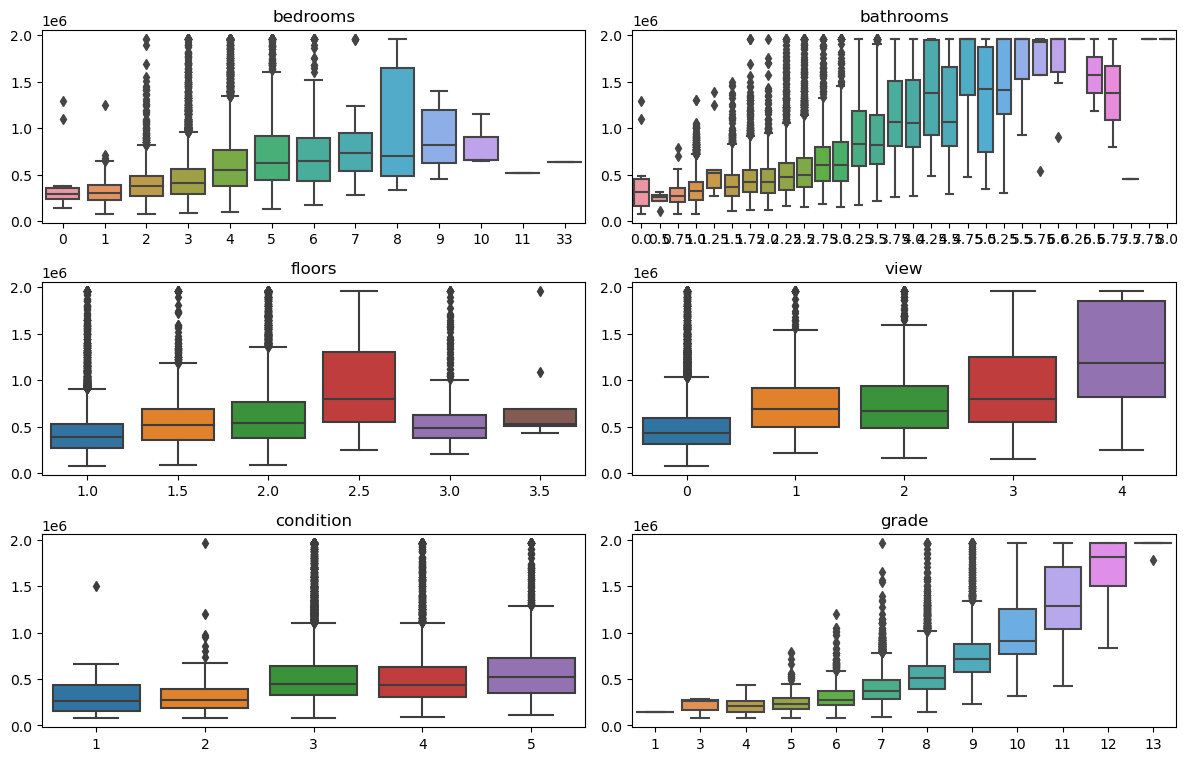

In [14]:
def outliers_discrete():
    plt.figure(figsize=(12, 10), tight_layout=True)
    columns = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']
    
    for i, var in enumerate(columns, 1):
        plt.subplot(4, 2, i) 
        sns.boxplot(data=df, x=var, y='price').set(title=var, xlabel=None, ylabel=None)
    plt.show()
        
outliers_discrete()

> Among these variables, the most suspicious value is 33 in the `bedrooms` box plot. The other values remain continuous. At this step we can spot high correlation with `grade` and moderate with `bedrooms`, `bathrooms` and `view`.

In [15]:
# find records with 33 bedrooms
df.query('`bedrooms` == 33')

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,20140625T000000,640000.0,33,1.75,1620.0,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700


> Based on square footage, number of floors, and price, this is an outlier and the value of bedrooms is probably 3. This row will be updated.

In [16]:
df.at[15870, 'bedrooms'] = 3

### 2. Feature Engineering

The `date` column is useless for further EDA due to the fact that it is a string varaiable. Still, we can extract some information from it and create new features:
* year of sale,
* month of sale,
* day of month of sale.

In [17]:
# extract year, month and day of sale
df['year'] = df['date'].str[:4].astype('int32')
df['month'] = df['date'].str[4:6].astype('int32')
df['day'] = df['date'].str[6:8].astype('int32')

The `yr_renovated` contains lots of zeros. We can replace this column with new values - the differences between year of renovation and year of purchase.

In [18]:
# replace 'yr_renovated'
df['yr_renovated'] = df['year'] - df['yr_renovated']

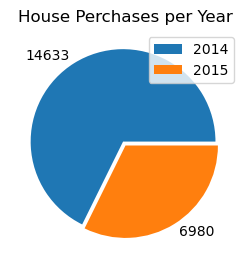

In [19]:
def year_purchases():
    y = df['year'].value_counts().values
    
    plt.figure(figsize=(3, 3))
    plt.pie(y, labels=[f'{y[0]}', f'{y[1]}'], explode=[0.05, 0])
    plt.title('House Perchases per Year')
    plt.legend(loc='upper right', labels=['2014', '2015'])
    plt.show()
    
year_purchases()

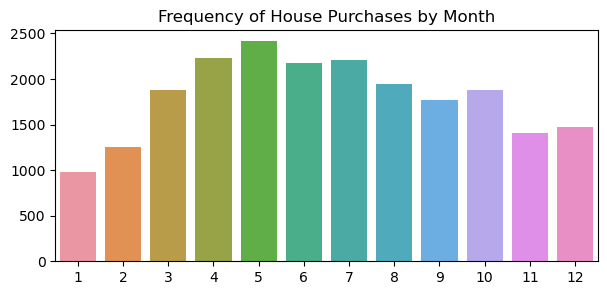

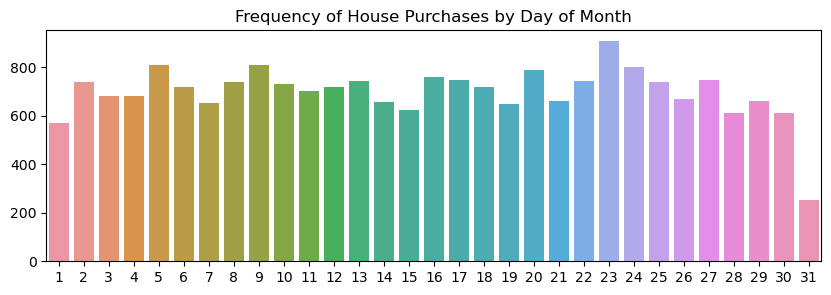

In [20]:
def plot_frequency():
    month_group = df.groupby(by=['month'])
    month_freq = month_group.size()
    
    plt.figure(figsize=(7, 3))
    month_plot = sns.barplot(data=df, x=month_freq.index, y=month_freq.values)
    month_plot.set(title='Frequency of House Purchases by Month', xlabel=None, ylabel=None)
    plt.show()
    
    day_group = df.groupby(by=['day'])
    day_freq = day_group.size()
    
    plt.figure(figsize=(10, 3))
    day_plot = sns.barplot(data=df, x=day_freq.index, y=day_freq.values)
    day_plot.set(title='Frequency of House Purchases by Day of Month', xlabel=None, ylabel=None)
    plt.show()

plot_frequency()

> Most sales are done in the spring and summer months. In terms of day of month, there are no significant trends. The 31st day has the least purchases but this is also due to the fact that not all months have this amount of days (February, April, June, etc.).

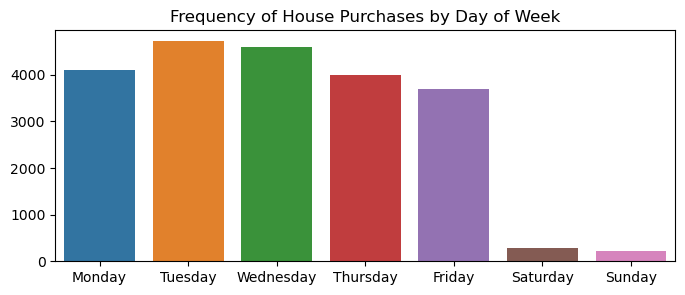

In [21]:
def frequency_week():
    mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    
    days = pd.to_datetime(df['date'].str[:8], format='%Y-%m-%d').dt.dayofweek.map(mapping)
    
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_week = days.value_counts().reindex(day_order)
    
    plt.figure(figsize=(8, 3))
    day_week = sns.barplot(data=df, x=day_week.index, y=day_week.values)
    day_week.set(title='Frequency of House Purchases by Day of Week', xlabel=None, ylabel=None)
    plt.show()
    
frequency_week()

> Weekends have the least sales which should not be surprising. Most transactions are finalized at the first half of week.

Previously, we noticed that to a certain degree the price seems to go down as homes are further away from the city's downtown. A new feature will be created: we will calculatd distances between city's center and houses.

In [22]:
from math import sin, cos, sqrt, atan2, radians

p = [47.608013, -122.335167] # Seattle's Downtown coordinates

# distances in km's (Haversine's formula)
def distance(p, q):
    dlat = radians(p[0]) - radians(q[0])
    dlong = radians(p[1]) - radians(q[1])
    R = 6371.0 # Earth's radius in [km]
    
    a = sin(dlat / 2)**2 + cos(radians(p[0])) * cos(radians(q[0])) * sin(dlong / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return c * R

# perform example
distance(p, q=[47.5112, -122.257])

12.25930881030136

In [23]:
list_dist = []

# calculate distances and set new column
for i in range(len(df)):
    list_dist.append(distance(p, q=[df.iloc[i]['lat'], df.iloc[i]['long']]))
    
df['distance'] = list_dist

# remove irrevelant column
df.drop(['date'], axis=1, inplace=True)

### 3. Multicollinearity and Feature Selection

Multicollinearity is problematic in the regression as it leads to a biased and unstable estimation of regression coefficients, increases the variance and standard error of regression coefficients, and decreases the statistical power. A model with high multicollinearity returns predictions that are very susceptible to small noise fluctuations.

Variance inflation factor (VIF) is a most commonly used metric for measuring the degree of multicollinearity between the independent variable. There is no universally accepted range for VIF values for multicollinearity detection. In most cases, it is advisable to have VIF < 5. VIF value above 5, suggests presence of strong multicollinearity with some predictor variables. Note that a constant/intercept must be added to calculate the VIF.

To fix multicollinearity we can remove predictors causing multicollinearity.

In [24]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def vif_metrics():
    X = df.drop(columns=['price'], axis=1)
    X = add_constant(X)
    
    # get VIF scores and display
    vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    df_vif = pd.DataFrame(zip(X.columns, vif), columns=['Feature', 'VIF']).sort_values(by='VIF', ascending=False)
    
    return df_vif.style.hide(axis='index')

vif_metrics()

Feature,VIF
const,55167634.727344
sqft_living,175.430798
sqft_above,147.280897
sqft_basement,42.111857
distance,3.998563
sqft_lot15,3.504194
grade,3.477795
sqft_lot,3.452815
bathrooms,3.314330
sqft_living15,3.058641


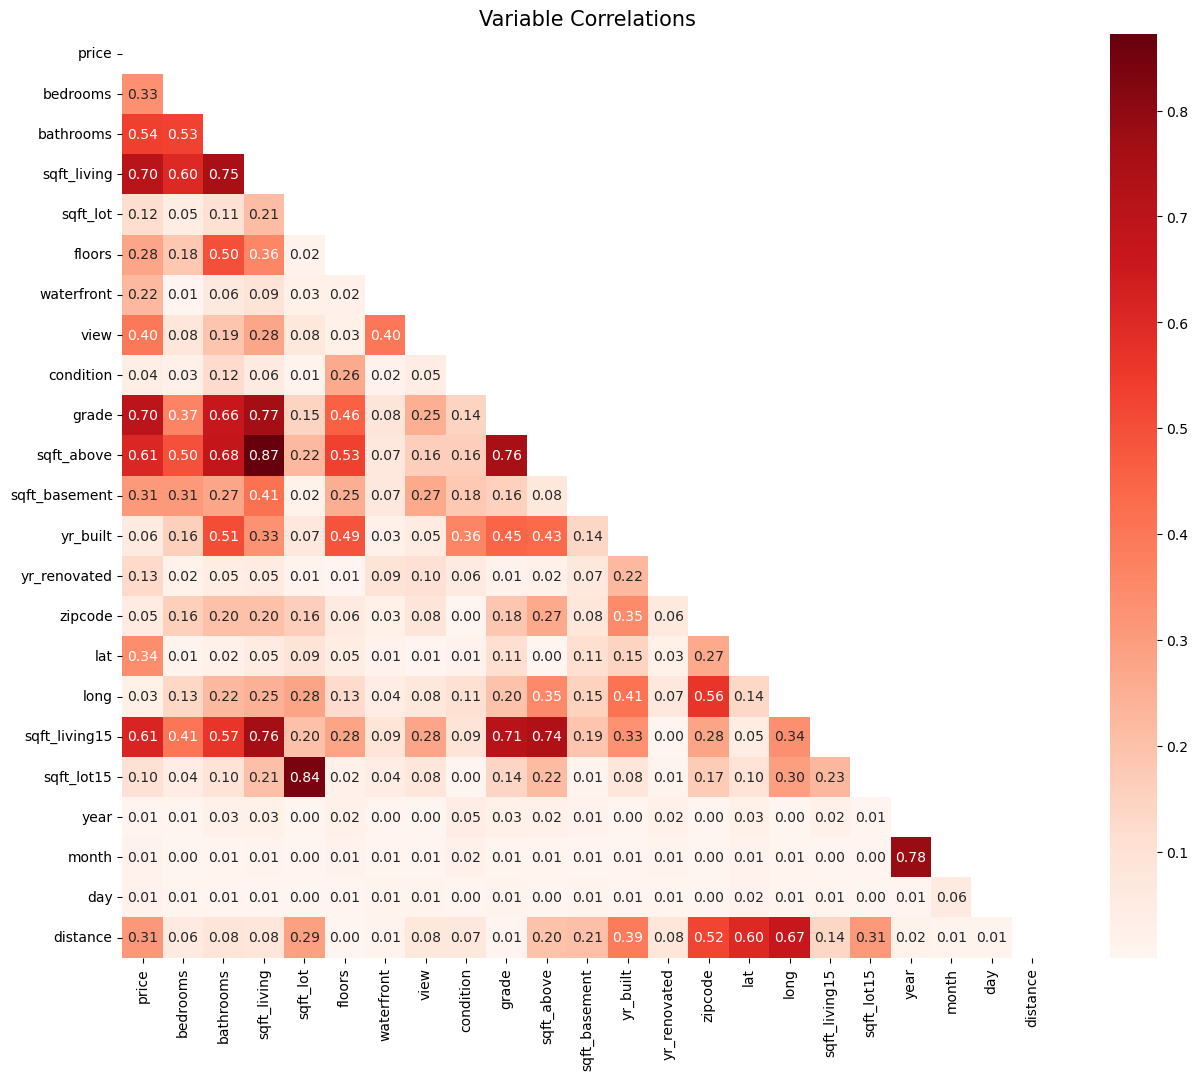

In [25]:
def var_correlations():
    corr = df.corr().abs()
    mask_ = np.triu(np.ones_like(corr, dtype=np.bool_))
    
    plt.figure(figsize=(15, 12))
    sns.heatmap(data=corr, mask=mask_, cmap='Reds', fmt='0.2f', annot=True)
    plt.title('Variable Correlations', fontsize=15)
    plt.show()
    
var_correlations()

Based on the VIF scores and correlation matrix, we will apply these steps:
* `sqft_living15` has high correlations with: `bathrooms`, `sqft_living`, `grade`, and `sqft_above`. We need to drop it to avoid multi-correlation and increase the model performance.
* `sqft_lot15` has similar meaning to `sqft_living15` and will also be dropped.
* `sqft_above` will be dropped due to the fact that it is a component of `sqft_living` - area without basement.

In [26]:
# export transformed data
df_final = df.drop(columns=['sqft_living15', 'sqft_lot15', 'sqft_above'], axis=1)
try:
    df_final.to_csv('kc_house_data.csv', index=False)
except:
    print('Something went wrong')

### 4. Statistical Tests

Lastly, we will conduct a few examples of statistical tests to provide answers for our preliminary and exploratory questions about which features affect housing prices. We will compare categorical features with the price ([chart](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*2hGMrCjLtVKtOKD_QnyuWA.png)).

**Question 1. Does a real estate with waterfront have any affect on retail price?**

To find the answer, we will apply a Welch's t-test which does not assume equal population variance to compare the means of two independent sample populations, which in this case are the means of the sample populations of houses with waterfronts and houses without waterfronts.

**Difference of Two Means**

$$H_0: \mu_1 = \mu_2$$

The null hypothesis is that there is no statistically significant difference between the housing price means of the two groups: waterfront and no waterfront.

$$H_a: \mu_1 \neq \mu_2$$

The alternate hypothesis is that there is statistically significant difference between the housing price means of the two groups.

In [27]:
from scipy.stats import ttest_ind

def question_1():
    waterfront = df[df['waterfront'] == 1]
    no_waterfront = df[df['waterfront'] == 0]
    p_value = ttest_ind(a=waterfront['price'], b=no_waterfront['price'], equal_var=False)[1]
    
    print('P-value for t-test: {:.6f}'.format(p_value))
    if p_value < 0.05:
        print(('\nWe reject the null hypothesis, and the sample populations are statistical different.'),
              ('Price is correlated with whether the house has a waterfront or not.'))
    else:
        print('Do not reject null hypothesis.')
        
question_1()

P-value for t-test: 0.000000

We reject the null hypothesis, and the sample populations are statistical different. Price is correlated with whether the house has a waterfront or not.


**Question 2. Does a renovated real estate have any affect on retail price?**

Again, we will apply a Welch's t-test.

$$H_0: \mu_1 = \mu_2$$

The null hypothesis is that there is no statistically significant difference between the housing price means of the two groups: renovated and not renovated.

$$H_a: \mu_1 \neq \mu_2$$

The alternate hypothesis is that there is statistically significant difference between the housing price means of the two groups.

In [28]:
# reminder: in our case, houses which were NOT renovated will have values equal 2014 or 2015; before adjusting they were zeros
def question_2():
    renovated = df[(df['yr_renovated'] != 2014) & (df['yr_renovated'] != 2015)]
    not_renovated = df[(df['yr_renovated'] == 2014) | (df['yr_renovated'] == 2015)]
    p_value = ttest_ind(a=renovated['price'], b=not_renovated['price'], equal_var=False)[1]
    
    print('P-value for t-test: {:.6f}'.format(p_value))
    if p_value < 0.05:
        print(('\nWe reject the null hypothesis, and the sample populations are statistical different.'),
              ('Price is correlated with whether the house has been renovated or not.'))
    else:
        print('Do not reject null hypothesis.')
        
question_2()

P-value for t-test: 0.000000

We reject the null hypothesis, and the sample populations are statistical different. Price is correlated with whether the house has been renovated or not.


**Question 3. Does the real estate's condition have any affect on retail price?**

To find the answer, we will apply the one-way ANOVA to compare variance between multiple means.

**One-Way ANOVA for Variance Between Multiple Means (Groups)**

$$H_0: \mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5$$

The null hypothesis is that there is no statistically significant difference between the housing price means and means of different conditions.

<p style='text-align: center;'>$H_a: \mu_1 \neq \mu_2$ or $\mu_2 \neq \mu_3$ or $\mu_3 \neq \mu_4...$</p>

The alternate hypothesis is that there is statistically significant difference between the housing price means of at least one of the conditions.

In [29]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def question_3():
    formula = 'price ~ condition'
    lm_condition = ols(formula, df).fit()
    anova_condition = anova_lm(lm_condition, type=2)
    
    print('F-stat probability: {:.6f}'.format(anova_condition['PR(>F)'][0]))
    if anova_condition['PR(>F)'][0] < 0.05:
        print(('\nWe reject the null hypothesis, and the sample populations are statistical different.'),
              ('Price is correlated with at least one of the housing conditions.'))
    else:
        print('Do not reject null hypothesis.')
    
question_3()

F-stat probability: 0.000000

We reject the null hypothesis, and the sample populations are statistical different. Price is correlated with at least one of the housing conditions.


**Question 4. Does the real estate's grade have any affect on retail price?**

Again, to answer this question we will apply the one-way ANOVA.

$$H_0: \mu_1 = \mu_2 = \mu_3 = \mu_4 = \mu_5 = \mu_6 = \mu_7 = \mu_8 = \mu_9 = \mu_{10} = \mu_{11} = \mu_{12} = \mu_{13}$$

The null hypothesis is that there is no statistically significant difference between the housing price means and means of different grades.

<p style='text-align: center;'>$H_a: \mu_1 \neq \mu_2$ or $\mu_2 \neq \mu_3$ or $\mu_3 \neq \mu_4...$</p>

The alternate hypothesis is that there is statistically significant difference between the housing price means of at least one of the grades.

In [30]:
def question_4():
    formula = 'price ~ grade'
    lm_condition = ols(formula, df).fit()
    anova_condition = anova_lm(lm_condition, type=2)
    
    print('F-stat probability: {:.6f}'.format(anova_condition['PR(>F)'][0]))
    if anova_condition['PR(>F)'][0] < 0.05:
        print(('\nWe reject the null hypothesis, and the sample populations are statistical different.'),
              ('Price is correlated with at least one of the housing grades.'))
    else:
        print('Do not reject null hypothesis.')
    
question_4()

F-stat probability: 0.000000

We reject the null hypothesis, and the sample populations are statistical different. Price is correlated with at least one of the housing grades.


To be continued. Next notebook (part 2) will contain price estimations achieved with an artificial neural network.